In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Простейший метод эволюции ОДУ - метод Эйлера
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [3]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,),
            (z, t) + tuple(self.parameters()),
            grad_outputs=(a),
            allow_unused=True,
            retain_graph=True,
        )
        # метод grad автоматически суммирует градиенты для всех элементов батча, надо expand их обратно
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters) if len(flat_parameters) > 0 else Tensor()

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t + 1], func)
                z[i_t + 1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Динамика аугментированной системы, которую надо эволюционировать обратно во времени
        def augmented_dynamics(aug_z_i, t_i):
            """
            Тензоры здесь - это срезы по времени
            t_i - тензор с размерами: bs, 1
            aug_z_i - тензор с размерами: bs, n_dim*2 + n_params + 1
            """
            z_i, a = (
                aug_z_i[:, :n_dim],
                aug_z_i[:, n_dim : 2 * n_dim],
            )  # игнорируем параметры и время

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(
                    z_i, t_i, grad_outputs=a
                )  # bs, *z_shape
                adfdz = (
                    adfdz.to(z_i)
                    if adfdz is not None
                    else torch.zeros(bs, *z_shape).to(z_i)
                )
                adfdp = (
                    adfdp.to(z_i)
                    if adfdp is not None
                    else torch.zeros(bs, n_params).to(z_i)
                )
                adfdt = (
                    adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)
                )

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz для удобства
        with torch.no_grad():
            ## Создадим плейсхолдеры для возвращаемых градиентов
            # Распространенные назад сопряженные состояния, которые надо поправить градиентами от наблюдений
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # В отличие от z и p, нужно вернуть градиенты для всех моментов времени
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len - 1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Рассчитаем прямые градиенты от наблюдений
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(
                    torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1)
                )[:, 0]

                # Подправим ими сопряженные состояния
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Упакуем аугментированные переменные в вектор
                aug_z = torch.cat(
                    (
                        z_i.view(bs, n_dim),
                        adj_z,
                        torch.zeros(bs, n_params).to(z),
                        adj_t[i_t],
                    ),
                    dim=-1,
                )

                # Решим (эволюционируем) аугментированную систему назад во времени
                aug_ans = ode_solve(aug_z, t_i, t[i_t - 1], augmented_dynamics)

                # Распакуем переменные обратно из решенной системы
                adj_z[:] = aug_ans[:, n_dim : 2 * n_dim]
                adj_p[:] += aug_ans[:, 2 * n_dim : 2 * n_dim + n_params]
                adj_t[i_t - 1] = aug_ans[:, 2 * n_dim + n_params :]

                del aug_z, aug_ans

            ## Подправим сопряженное состояние в нулевой момент времени прямыми градиентами
            # Вычислим прямые градиенты
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(
                torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1)
            )[:, 0]

            # Подправим
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0.0, 1.0]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

Применение

In [6]:
class ArbitraryFunctionODEF(ODEF):
    def __init__(self, func_x, func_y):
        super(ArbitraryFunctionODEF, self).__init__()
        self.func_x = func_x
        self.func_y = func_y
        

    def forward(self, z, t):
        x_ = z[0][0]
        y_ = z[0][1]
        return Tensor([[self.func_x(x_, y_, t), self.func_y(x_, y_, t)]])

In [7]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim + 1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [8]:
def to_np(x):
    return x.detach().cpu().numpy()

In [9]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [10]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29 * 5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32

    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(
            np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[
                :max_points_num
            ]
        )

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(
                obs=[obs],
                times=[times],
                trajs=[z_p],
                save=f"assets/imgs/{name}/{i}.png",
            )
            clear_output(wait=True)

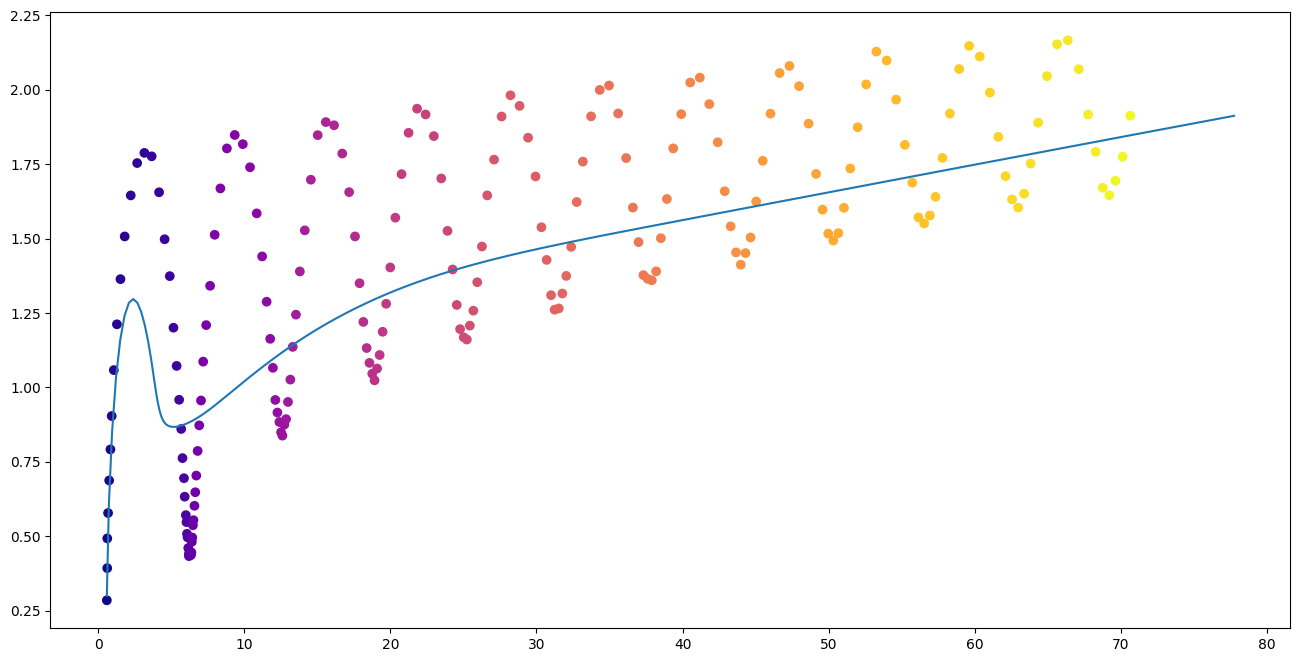

In [11]:
func = ArbitraryFunctionODEF(lambda x, y, t: y**2, lambda x, y, t: np.sin(x))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)